In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import mdn
from sklearn.ensemble import RandomForestClassifier

Using TensorFlow backend.
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="2"

SR = 44100
blocksize = 88200
overlap = 44100

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [7]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 0,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1 ,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
import time
import librosa
import numpy as np
import soundfile as sf

def load_fold_audio_blockwise(fld, data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    items = []
    h_cat = []
    cat = []
    for i, sample in f_df.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        SR = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_cat.append(sample.h_category)
            cat.append(sample.target)
        if debug:
            print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            target.append(sample.h_category)
        if debug:
            print("Done")
    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(target)

In [11]:
c_data, targets, c_targets = load_fold_audio_blockwise(1, dataset, blocksize, overlap)
# c_data, targets = load_fold_audio(1, dataset)
print(c_data.shape)

	Processing Time: 3.0663161277770996
(1506, 1, 88200)


In [12]:
a_data = c_data[targets == 0]
a_targ = c_targets[targets == 0]
i_data = c_data[targets == 1]
i_targ = c_targets[targets == 1]

In [13]:
names_a = []
for name in np.unique(a_targ):
    names_a.append(classes[name])
names_i = []
for name in np.unique(i_targ):
    names_i.append(classes[name])
print(names_a)
print(names_i)

['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow', 'crickets', 'chirping_birds', 'crying_baby', 'sneezing', 'clapping', 'breathing', 'coughing', 'laughing', 'snoring']
['rain', 'sea_waves', 'crackling_fire', 'water_drops', 'wind', 'pouring_water', 'toilet_flush', 'thunderstorm', 'footsteps', 'brushing_teeth', 'drinking_sipping', 'door_wood_knock', 'mouse_click', 'keyboard_typing', 'door_wood_creaks', 'can_opening', 'washing_machine', 'vacuum_cleaner', 'clock_alarm', 'clock_tick', 'glass_breaking', 'helicopter', 'chainsaw', 'siren', 'car_horn', 'engine', 'train', 'church_bells', 'airplane', 'fireworks', 'hand_saw']


In [14]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
                        c_data, targets, test_size=0.20, random_state=42)

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import keras
import kapre
from datetime import datetime
now = datetime.now()
import librosa
from librosa import display

def check_model(model):
    model.summary(line_length=80, positions=[.33, .65, .8, 1.])

    batch_input_shape = (2,) + model.input_shape[1:]
    batch_output_shape = (2,) + model.output_shape[1:]
    model.compile('sgd', 'mse')
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)

def visualise_model(model, src, logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    print(src.shape)
    src = src[:nsp_src]
    src_batch = src[np.newaxis, :]
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    display.specshow(result, y_axis='linear', fmin=800, fmax=8000, sr=SR)
    plt.show()
    
def evaluate_model(model, c_data):
    pred = model.predict(x=c_data)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[:, :, :, 0]
#     result = np.swapaxes(result, 1, 2)
    print(result.shape)
    return result

________________________________________________________________________________
Layer (type)              Output Shape              Param #     
melspectrogram_1 (Melspec (None, 128, 345, 1)       296064      
Total params: 296,064
Trainable params: 0
Non-trainable params: 296,064
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 5s 3s/step - loss: 1437.5664
(1, 88200)


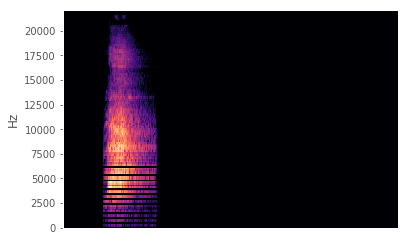

(1506, 128, 345)
________________________________________________________________________________
Layer (type)              Output Shape              Param #     
spectrogram_1 (Spectrogra (None, 257, 345, 1)       263168      
Total params: 263,168
Trainable params: 0
Non-trainable params: 263,168
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 0s 78ms/step - loss: 1182.6503
(1, 88200)


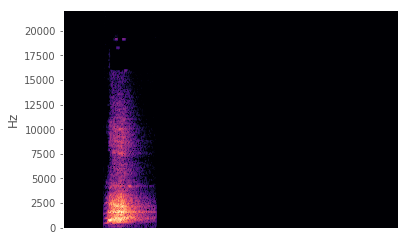

(1506, 257, 345)


In [16]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.filterbank import Filterbank
import numpy as np

model = Sequential()
model.add(Melspectrogram(
    sr=44100,
    n_mels=128,
    power_melgram=2.0,
    return_decibel_melgram = True,
    input_shape=(1, blocksize),
    trainable_fb=False
))

check_model(model)
visualise_model(model, c_data[1])
mfccs = evaluate_model(model, c_data)

model = Sequential()
model.add(Spectrogram(
    return_decibel_spectrogram = True,
    input_shape=(1, blocksize)
))

check_model(model)
visualise_model(model, c_data[1])
spec = evaluate_model(model, c_data)

# Deep Net
Separate into classes

In [17]:
import librosa

def preprocess(mel_spec, spec):
    # Calculate the first 13 mfcc's
    mfccs = librosa.feature.mfcc(S=mel_spec, n_mfcc=13)
    # Get first derivative of the mfccs
    delta = librosa.feature.delta(mfccs)
    # Get second derivative of mfccs
    delta_2 = librosa.feature.delta(mfccs, order=2)
    
    spec_contrast = librosa.feature.spectral_contrast(S=spec)
    
    return np.vstack((mfccs[1:], delta, delta_2, spec_contrast)).transpose()

In [18]:
a_mfcc = mfccs[targets == 0]
a_spec = spec[targets == 0]
a_targ = c_targets[targets == 0]
i_mfcc = mfccs[targets == 1]
i_spec = spec[targets == 1]
i_targ = c_targets[targets == 1]

In [19]:
start_time = time.time()

new_dat = []
for i in range(0, a_spec.shape[0]):
    new_dat.append(preprocess(a_mfcc[i], a_spec[i]))

print(new_dat[0].shape)
print("\tProcessing Time: " + str(time.time() - start_time))

(345, 45)
	Processing Time: 6.959433078765869


In [20]:
new_dat = np.average(new_dat, axis=1)
print(new_dat.shape)

(564, 45)


In [21]:
new_dat = np.vstack(new_dat)
print(new_dat.shape)

(564, 45)


In [22]:
print(a_targ.shape)

(564,)


# Animal Sounds

In [23]:
train_X, test_X, train_y, test_y = train_test_split(
                        new_dat, a_targ, test_size=0.20, random_state=56)

In [24]:
from keras.layers import Dense, Dropout

def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(45,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(19, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Paralle

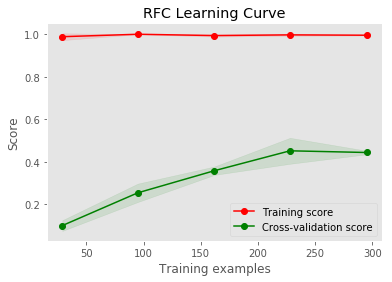

In [25]:
anim = RandomForestClassifier(verbose=True)
plot_learning_curve(anim, 'RFC Learning Curve', train_X, train_y).show()

In [26]:
anim.fit(train_X, train_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=True,
            warm_start=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


0.5486725663716814
Confusion matrix, without normalization
[[3 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 2 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0]
 [0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 1 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 4 1 0 0 0 1 0 0 1 0 1 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 3 0 0 0 1 1 0 0 0 0 0 1]
 [2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 1 0 0 0 1 2 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 1 0 0 0 0 3 0 0 0 0]
 [1 0 0 1 0 0 0 0 0 0 0 0 0 3 0 3 0 0 0]
 [0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 5 1]
 [0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 2]]


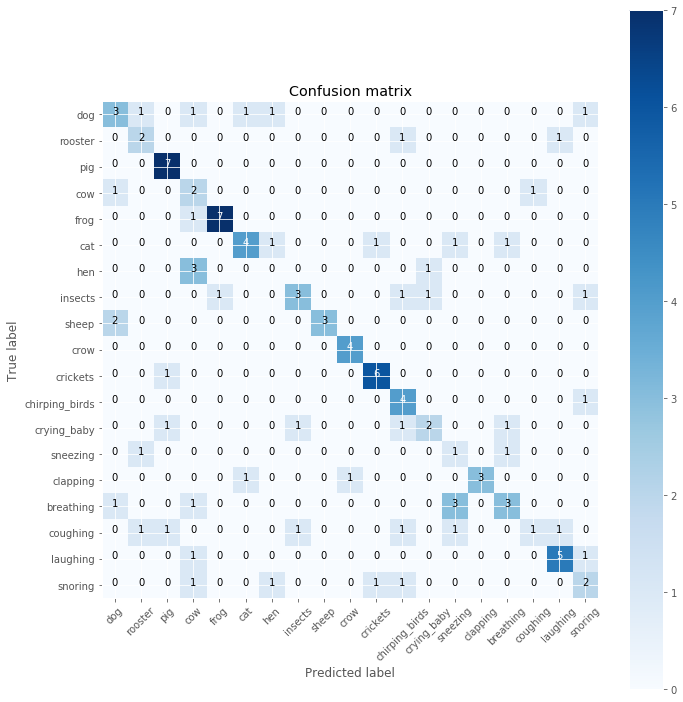

In [27]:
pred = anim.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

# Interacting Materials

In [28]:
start_time = time.time()

new_dat = []
for i in range(0, i_spec.shape[0]):
    new_dat.append(preprocess(i_mfcc[i], i_spec[i]))

print(new_dat[0].shape)
print("\tProcessing Time: " + str(time.time() - start_time))

(345, 45)
	Processing Time: 11.675217390060425


In [29]:
new_dat = np.average(new_dat, axis=1)
print(new_dat.shape)

(942, 45)


In [30]:
print(i_targ.shape)

(942,)


In [31]:
train_X, test_X, train_y, test_y = train_test_split(
                        new_dat, i_targ, test_size=0.20, random_state=75)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Paralle

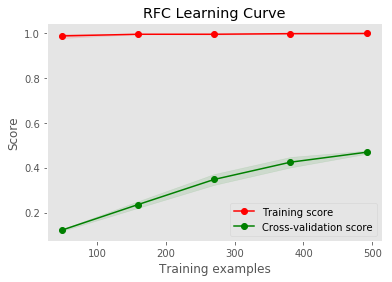

In [32]:
inter = RandomForestClassifier(verbose=True)
plot_learning_curve(inter, 'RFC Learning Curve', train_X, train_y).show()

In [33]:
inter.fit(train_X, train_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=True,
            warm_start=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


0.544973544973545
Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 6 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [0 0 6 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 1 0 0 0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 4 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 0 0 0 2 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 2 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 2 

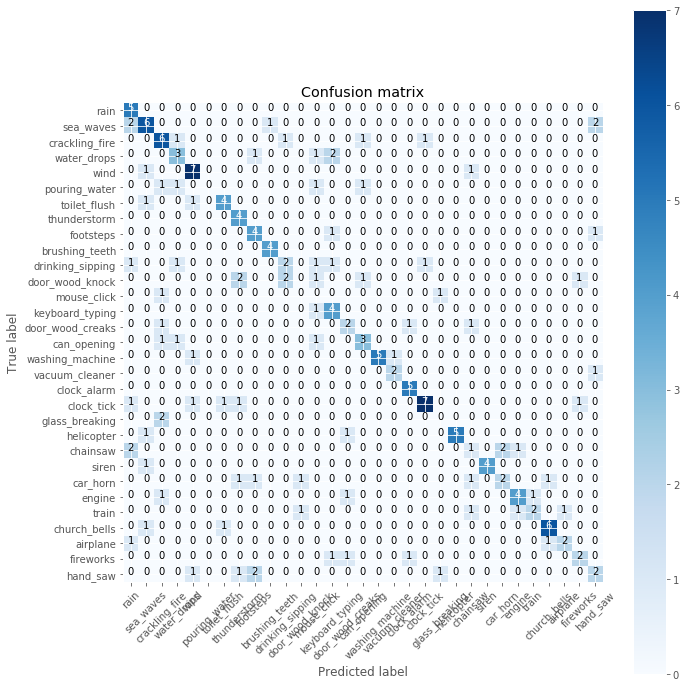

In [34]:
pred = inter.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_i)
plt.show()

# All Data

In [35]:
X2, y2, yy2 = load_fold_audio_blockwise(2, dataset, blocksize, overlap)
X3, y3, yy3 = load_fold_audio_blockwise(3, dataset, blocksize, overlap)
X4, y4, yy4 = load_fold_audio_blockwise(4, dataset, blocksize, overlap)
X5, y5, yy5 = load_fold_audio_blockwise(5, dataset, blocksize, overlap)

	Processing Time: 3.287875175476074
	Processing Time: 3.0790088176727295
	Processing Time: 3.151221990585327
	Processing Time: 3.776685953140259


In [36]:
X = np.vstack((X2, X3, X4, X5))
print(X.shape)

(6058, 1, 88200)


In [37]:
y = np.concatenate((y2, y3, y4, y5))
print(y.shape)

(6058,)


In [38]:
yy = np.concatenate((yy2, yy3, yy4, yy5))
print(yy.shape)

(6058,)


________________________________________________________________________________
Layer (type)              Output Shape              Param #     
melspectrogram_2 (Melspec (None, 128, 345, 1)       296064      
Total params: 296,064
Trainable params: 0
Non-trainable params: 296,064
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 0s 124ms/step - loss: 1432.5649
(1, 88200)


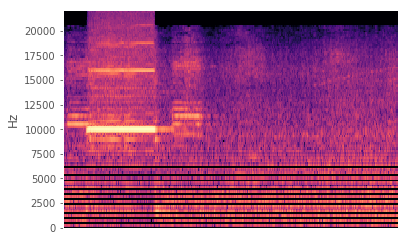

(6058, 128, 345)
________________________________________________________________________________
Layer (type)              Output Shape              Param #     
spectrogram_2 (Spectrogra (None, 257, 345, 1)       263168      
Total params: 263,168
Trainable params: 0
Non-trainable params: 263,168
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 0s 116ms/step - loss: 1172.0771
(1, 88200)


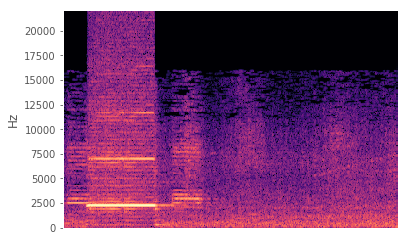

(6058, 257, 345)


In [39]:
model = Sequential()
model.add(Melspectrogram(
    sr=44100,
    n_mels=128,
    power_melgram=2.0,
    return_decibel_melgram = True,
    input_shape=(1, blocksize),
    trainable_fb=False
))

check_model(model)
visualise_model(model, X[1])
mfccs = evaluate_model(model, X)

model = Sequential()
model.add(Spectrogram(
    return_decibel_spectrogram = True,
    input_shape=(1, blocksize)
))

check_model(model)
visualise_model(model, X[1])
spec = evaluate_model(model, X)

In [40]:
a_mfcc = mfccs[y == 0]
a_spec = spec[y == 0]
a_targ = yy[y == 0]
i_mfcc = mfccs[y == 1]
i_spec = spec[y == 1]
i_targ = yy[y == 1]

In [41]:
start_time = time.time()

new_dat = []
for i in range(0, a_spec.shape[0]):
    new_dat.append(preprocess(a_mfcc[i], a_spec[i]))

print(new_dat[0].shape)
print("\tProcessing Time: " + str(time.time() - start_time))

start_time = time.time()

(345, 45)
	Processing Time: 25.740737915039062


In [42]:
new_dat = np.average(new_dat, axis=1)
print(new_dat.shape)

(2278, 45)


In [43]:
print(a_targ.shape)

(2278,)


0.21202809482001755
Confusion matrix, without normalization
[[30  9  1 22  3  7 12 10  5  2  0  1  1  7  4  1  2  3  0]
 [12 21  1  6  2  3  5  5 12 19  0  2  2 15  7  2  1  0  0]
 [ 3  4 22  4  1 10  4 14  3  6  0  3 14  0  2  1  7  9  7]
 [15  6  5 48  4  3  9  5 13  0  0  0  2  2  0  1  1  4  1]
 [ 7  3  5 15 46  7  5  0 18  9  2  2  2  0  4  1  0  1  1]
 [11 11  0 15  9 14  5  3  3  9  1  4  3  7  3  3  4  3  4]
 [13  6  7 20  1 10 17 11  3  4  0  5  8  2  4  3  3  3  3]
 [ 3  0  7 23  3  1  1 41  0  2  6 11  2  5  9  0  0  4  7]
 [ 8  5  5 13  7 10 10  2 41  5  0  3  6  1  6  1  2  3  0]
 [10 14  1 11 10  6 18  3 12 16  0  0  2  2 11  1  1  1  2]
 [ 3  2 10  6  6  6  2  6  2  8 30 26  6  0  4  0  0  2  9]
 [ 6  3  7 12 11  6  4  6  9  9 10 21  7  1  5  1  1  3  6]
 [ 4  5  6  9  1  3  2 12  6 14  3 22 18  0 17  1  3  0  1]
 [ 5  5  3  5  0  9  6  4  3  2  0  5  1 36  0  5  4  4  6]
 [ 9  1  5 22  3  7  4 17  2 10  0  1  1  1 39  1  1  1  1]
 [11  4  5 15  6  4 11 11  3  7  1  5  9

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


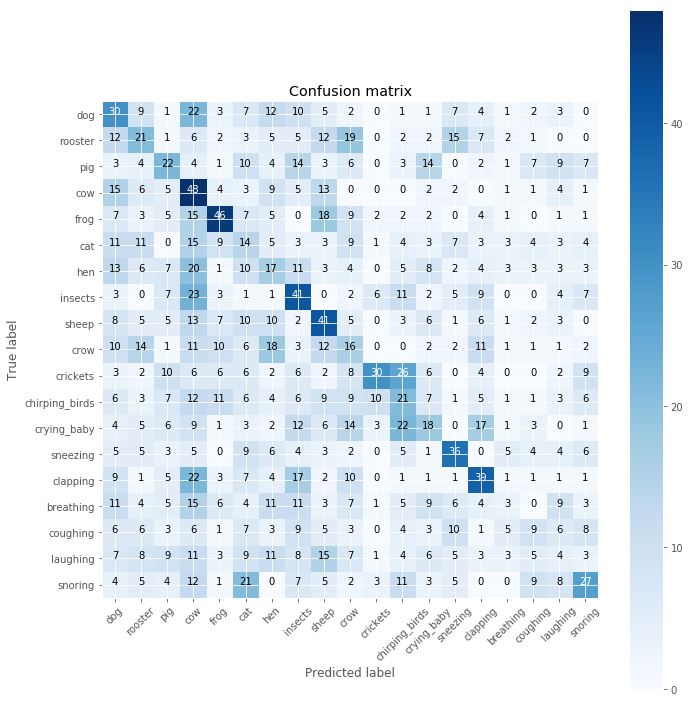

In [44]:
pred = anim.predict(new_dat)
print(metrics.accuracy_score(a_targ, pred))
cm = metrics.confusion_matrix(a_targ, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

In [45]:
start_time = time.time()

new_dat = []
for i in range(0, i_spec.shape[0]):
    new_dat.append(preprocess(i_mfcc[i], i_spec[i]))

print(new_dat[0].shape)
print("\tProcessing Time: " + str(time.time() - start_time))

start_time = time.time()

(345, 45)
	Processing Time: 45.52296996116638


In [46]:
new_dat = np.average(new_dat, axis=1)
print(new_dat.shape)

(3780, 45)


In [47]:
print(i_targ.shape)

(3780,)


0.17566137566137566
Confusion matrix, without normalization
[[28 13  0  0  3  1 12  1  1  6  0  0  1  0  1  0  5 17  0  0  1 13  3  0
   0  5  6  6  2  0  3]
 [ 6 52  1  0  6  0 13  0  1  2  0  0  1  0  0  0  3  8  0  0  1  0 24  0
   0  0  0  2  0  0  8]
 [ 6  1 57  3  1  1  2  3  3  6  4  1 12  3  1  5  2  1  1  2  4  0  0  0
   0  2  2  0  1  3  0]
 [ 0  0  9 11  0  4  1  7  6  0 12  1 11 12  1  7  0  0  5  7  9  0  1  0
   0  0  0  0  0  6  3]
 [ 0  2  1  5 13  1  0 22  2  0  0  0  0  1  0  0  1  1  0  8  0  0  3  5
   1  2 18 27 13  1  1]
 [ 5  7  4  7  4 21  7  2  9  8  1  3  4  8  6  2  1  2  3  3  6  0  2  4
   1  0  1  0  1  3  1]
 [13 14  5  3  5  1 22  1  4  8  0  0  1  1  4  0  6 11  1  1  2  1 11  0
   0  2  2  0  1  0  8]
 [ 0  0  2  1  4  0  1 62  4  0  5  4  3  0  1  0  0  0  0  1  0  0  0  0
   0  6  4  7 21  2  0]
 [ 3  7 11  4  4  2  4  9  9 10  6  1  3  9  4  1  2  0  2  7  1  1  3  0
   0  6  1  0  0  2 14]
 [11  1 16  5  2  7  0  1 10 27  1  0  1  7  8  2  1  0  8

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


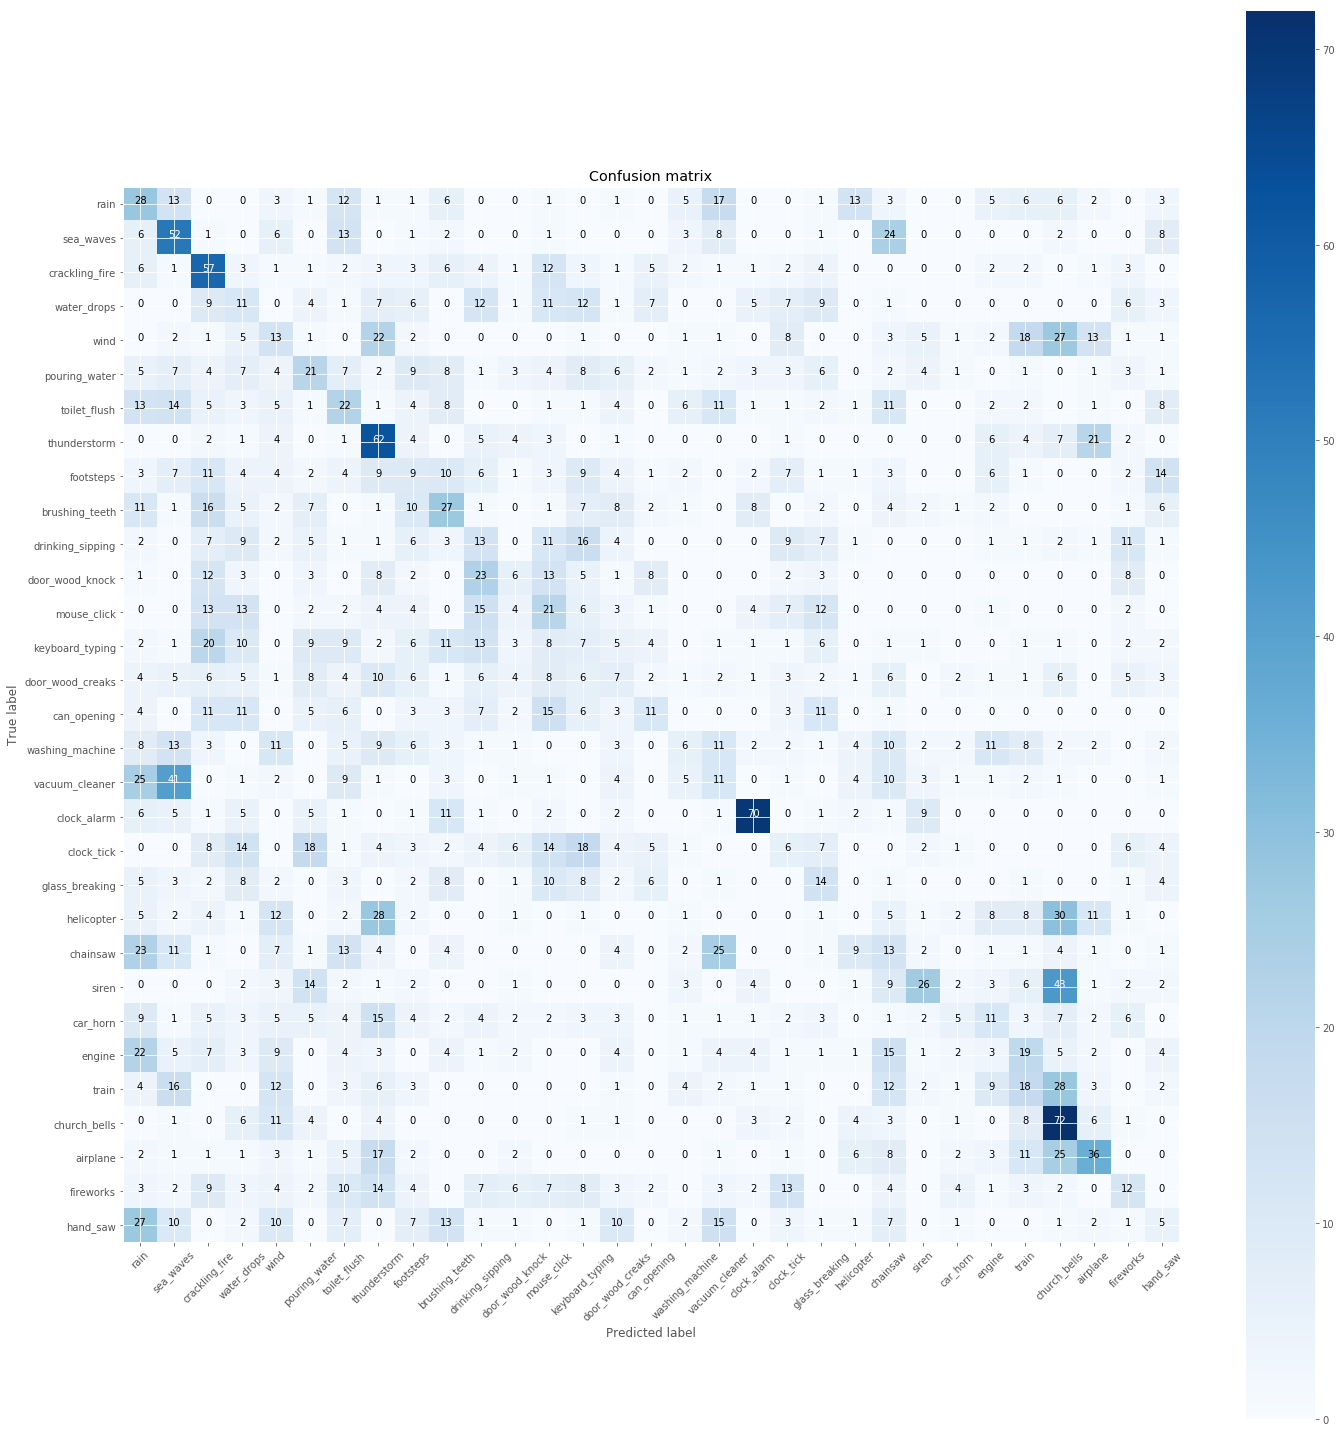

In [48]:
pred = inter.predict(new_dat)
print(metrics.accuracy_score(i_targ, pred))
cm = metrics.confusion_matrix(i_targ, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, names_i)
plt.show()